Xopt= [0.98032381 1.99171573 3.01640229 3.95431204 5.06151272 5.9701378 ]
cost_opt= 2.57359983101862e-07


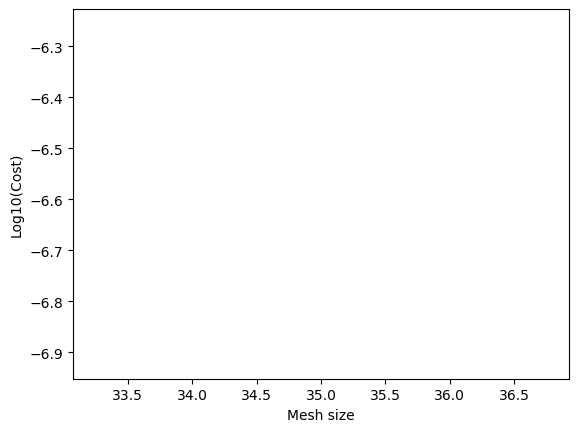

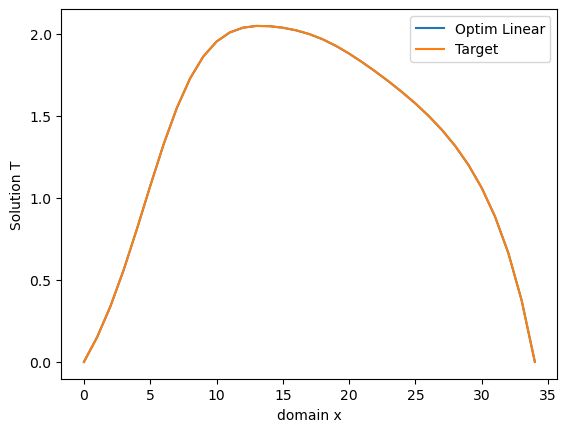

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 32
         Function evaluations: 280
         Gradient evaluations: 40
------------------------------------------------
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.6363165405745542e-06
        x: [ 9.944e-01  2.053e+00  2.731e+00  4.329e+00  5.264e+00
             5.597e+00]
      nit: 32
      jac: [ 2.175e-06 -2.731e-08 -4.051e-06  5.562e-06  1.245e-06
            -5.066e-06]
 hess_inv: [[ 8.538e+03 -8.809e+02 ... -3.553e+02  6.072e+02]
            [-8.809e+02  7.996e+02 ...  2.462e+02  4.268e+02]
            ...
            [-3.553e+02  2.462e+02 ...  2.175e+02  3.475e+02]
            [ 6.072e+02  4.268e+02 ...  3.475e+02  7.571e+02]]
     nfev: 280
     njev: 40
------------------------------------------------


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def ADRS(NX,xcontrol,Target):
        
    #u,t = -V u,x + k u,xx  -lamda u + f
    
    # PHYSICAL PARAMETERS
    K = 0.1     #Diffusion coefficient
    L = 1.0     #Domain size
    Time = 20.  #Integration time
    
    V=1
    lamda=1
    
    # NUMERICAL PARAMETERS
    NT = 1000   #Number of time steps max
    ifre=1000000  #plot every ifre time iterations
    eps=0.0001     #relative convergence ratio
    

    dx = L/(NX-1)                 #Grid step (space)
    dt = dx**2/(V*dx+K+dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5
    #print(dx,dt)

    ### MAIN PROGRAM ###

    # Initialisation
    x = np.linspace(0.0,1.0,NX)
    T = np.zeros((NX)) #np.sin(2*np.pi*x)
    F = np.zeros((NX))
    rest = []
    RHS = np.zeros((NX))

    for j in range (1,NX-1):
        for ic in range(len(xcontrol)):
            F[j]+=xcontrol[ic]*np.exp(-100*(x[j]-L/(ic+1))**2)
        
    dt = 0.5*dx**2/(V*dx+2*K+abs(np.max(F))*dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5

    #plt.figure(1)


    # Main loop en temps
    #for n in range(0,NT):
    n=0
    res=1
    res0=1
    while(n<NT and res>eps*res0): #
        n+=1
    #discretization of the advection/diffusion/reaction/source equation
        res=0
        for j in range (1, NX-1):
            xnu=K+0.5*dx*abs(V) 
            Tx=(T[j+1]-T[j-1])/(2*dx)
            Txx=(T[j-1]-2*T[j]+T[j+1])/(dx**2)
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            res+=abs(RHS[j])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0


        if (n == 1 ):
            res0=res

        rest.append(res)
    #Plot every ifre time steps
        # if (n%ifre == 0 or (res/res0)<eps):
        #     #print(n,res)
        #     plotlabel = "t = %1.2f" %(n * dt)
        #     plt.plot(x,T, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))
          

    # plt.plot(x,T)
    # plt.plot(x,Target)
    # plt.show()
    cost=np.dot(T-Target,T-Target)*dx #Riemann integral of J
    
    return cost,T

#%%

nbc=6
NX=30
nb_iter_refine=1

#define admissible solution for inverse problem
# Target=np.zeros(NX)
# xcible=np.arange(nbc)+1
# cost,Target=ADRS(NX,xcible,Target)
# plt.plot(Target)
# plt.show()

best_cost=1.e10
x_best=np.zeros(nbc)

cost_tab=np.zeros(nb_iter_refine)
NX_tab=np.zeros(nb_iter_refine)

for irefine in range(nb_iter_refine):
    
    NX+=5
    NX_tab[irefine]=NX

    Target=np.zeros(NX)    
    xcible=np.arange(nbc)+1
    cost_junk,Target=ADRS(NX,xcible,Target)
        
    # for i in range(NX):
    #     Target[i]=np.sin(2*np.pi*(i+1)/NX)
        
    xcontrol=np.zeros(nbc)
    cost,T0=ADRS(NX,xcontrol,Target)
    
    # plt.plot(T0)
    # plt.show()
    
    A=np.zeros((nbc,nbc))
    B=np.zeros(nbc)
    
    for ic in range(nbc):
        xic=np.zeros(nbc)
        xic[ic]=1
        cost,Tic=ADRS(NX,xic,Target)
        B[ic]=np.dot((Target-T0),Tic)/(NX-1)
        for jc in range(0,ic+1):
            xjc=np.zeros(nbc)
            xjc[jc]=1
            cost,Tjc=ADRS(NX,xjc,Target)
            A[ic,jc]=np.dot(Tic,Tjc)/(NX-1)

    for ic in range(nbc):            
        for jc in range(ic,nbc):
            A[ic,jc]=A[jc,ic]            
            
    # print("A=",A)
    # print("B=",B)
    
    xopt=np.linalg.solve(A, B)
    print("Xopt=",xopt)        
    cost_opt,T=ADRS(NX,xopt,Target)
    print("cost_opt=",cost_opt)
    cost_tab[irefine]=cost_opt
    
    if(best_cost>=cost_opt):
        best_cost=cost_opt
        T_opt=T.copy()
        x_best=xopt.copy()
        Target_opt=Target.copy()
        #print(np.shape(Target_opt),np.shape(T_opt))
    
    # plt.figure()
    # plt.plot(Target)
    # plt.plot(T)

plt.plot(NX_tab,np.log10(cost_tab))
plt.xlabel("Mesh size")
plt.ylabel("Log10(Cost)")
plt.show()

plt.plot(T_opt,label="Optim Linear")
plt.plot(Target_opt,label="Target")
plt.xlabel("domain x")
plt.ylabel("Solution T")
plt.legend()
plt.show()

#%%

#Using python optimizer

def functional(x):
    NX=28
    Target=np.zeros(NX)
    # for i in range(NX):
    #     Target[i]=np.sin(2*np.pi*(i+1)/NX)
    nbc=6
    xcible=np.arange(nbc)+1
    cost,Target=ADRS(NX,xcible,Target)
    cost,T=ADRS(NX,x,Target)
    return cost

#use python minimizer 
x0=np.zeros((nbc))
options = { "maxiter": 100, 'disp': True}
res = minimize(functional, x0, options=options)
print("------------------------------------------------")
print(res)
print("------------------------------------------------")


=== Génération de la surface J(x1, x2) ===


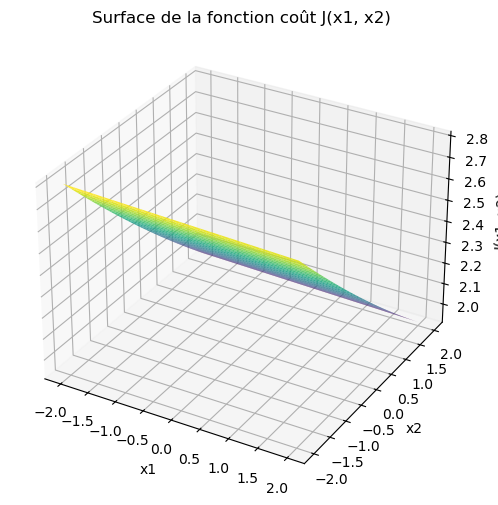

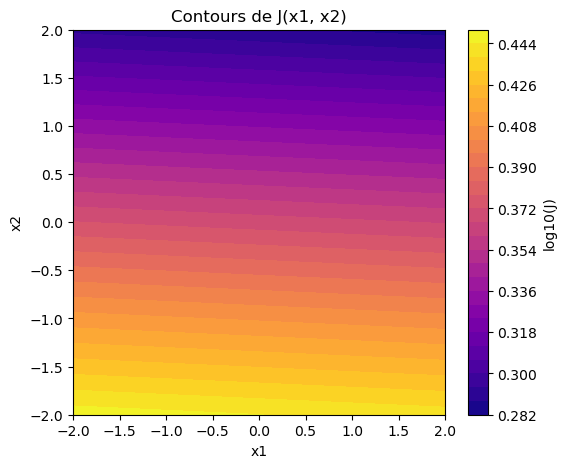

In [2]:
from mpl_toolkits.mplot3d import Axes3D

# -------------------------------
# Tracé de la surface J(x1, x2)
# -------------------------------

print("\n=== Génération de la surface J(x1, x2) ===")

# Nombre de contrôles total
nbc = 6
NX = 28

# Calcul du "Target" avec les contrôles idéaux (xcible)
Target = np.zeros(NX)
xcible = np.arange(nbc) + 1
cost_junk, Target = ADRS(NX, xcible, Target)

# Valeurs de base (contrôle fixe)
xcontrol_base = np.zeros(nbc)

# On fait varier les deux premiers contrôles
x1_vals = np.linspace(-2, 2, 25)
x2_vals = np.linspace(-2, 2, 25)

J_surface = np.zeros((len(x1_vals), len(x2_vals)))

# Boucle double pour échantillonnage
for i, x1 in enumerate(x1_vals):
    for j, x2 in enumerate(x2_vals):
        xcontrol = xcontrol_base.copy()
        xcontrol[0] = x1
        xcontrol[1] = x2
        cost, _ = ADRS(NX, xcontrol, Target)
        J_surface[i, j] = cost

# -------------------------------
# Tracé 3D
# -------------------------------
X1, X2 = np.meshgrid(x1_vals, x2_vals)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, J_surface.T, cmap='viridis', alpha=0.9)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("J(x1, x2)")
ax.set_title("Surface de la fonction coût J(x1, x2)")
plt.show()

# -------------------------------
# Tracé 2D (contours)
# -------------------------------
plt.figure(figsize=(6,5))
CS = plt.contourf(X1, X2, np.log10(J_surface.T), levels=30, cmap='plasma')
plt.colorbar(label="log10(J)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Contours de J(x1, x2)")
plt.show()
